<a href="https://colab.research.google.com/github/dileepyadavns/multivaraiate_time_series_forecasting/blob/main/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import matplotlib.pyplot as plt
# from pandas import read_csv
# from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM

In [106]:
dataset_train = pd.read_csv('/content/train.csv',header=0, index_col=0)  
dataset_train.head(2)

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
03-01-2015 01:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
03-01-2015 02:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0


In [3]:
print(type(dataset_train))
dataset_train.shape

<class 'pandas.core.frame.DataFrame'>


(43775, 16)

In [4]:
dataset_columns = dataset_train.columns.tolist()
dataset_columns

['nat_demand',
 'T2M_toc',
 'QV2M_toc',
 'TQL_toc',
 'W2M_toc',
 'T2M_san',
 'QV2M_san',
 'TQL_san',
 'W2M_san',
 'T2M_dav',
 'QV2M_dav',
 'TQL_dav',
 'W2M_dav',
 'Holiday_ID',
 'holiday',
 'school']

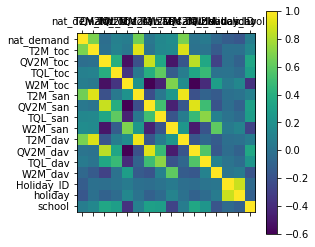

In [5]:
cor_cols = dataset_columns
plt.matshow(dataset_train.corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()

In [107]:
values = dataset_train.values
print(values.shape)
print(type(values))
values[0]

(43775, 16)
<class 'numpy.ndarray'>


array([9.70345000e+02, 2.58652588e+01, 1.85763820e-02, 1.61743160e-02,
       2.18505458e+01, 2.34824463e+01, 1.72717550e-02, 1.85537300e-03,
       1.03289487e+01, 2.26621338e+01, 1.65622220e-02, 9.60998500e-02,
       5.36414795e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [108]:
# normalized the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)
print(scaled_dataset[0])
scaled_dataset.shape

[0.5409399  0.24092133 0.61321832 0.03103044 0.55688809 0.19262007
 0.59236179 0.00380735 0.42043586 0.19103092 0.61106557 0.20105082
 0.52063079 0.         0.         0.        ]


(43775, 16)

In [109]:
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (43771, 1)
X (43771, 4, 16)


In [9]:
X.shape

(43771, 4, 16)

In [110]:
#Splitting the dataset
n_train = 24*365
train_X, test_X = X[n_train:,] , X[:n_train,]
print('train_X' ,train_X.shape)
print('test_X' ,test_X.shape)

train_y, test_y = Y[n_train:,] , Y[:n_train,]
print('train_y' ,train_y.shape)
print('test_y' ,test_y.shape)

train_X (35011, 4, 16)
test_X (8760, 4, 16)
train_y (35011, 1)
test_y (8760, 1)


In [16]:
test_X.shape

(8760, 4, 16)

In [17]:
test_y.shape

(8760, 1)

In [18]:
print(train_X)

[[[0.55050646 0.25591989 0.70528319 ... 0.         0.         0.        ]
  [0.53149897 0.24920588 0.68375298 ... 0.         0.         0.        ]
  [0.50939185 0.24375186 0.66147253 ... 0.         0.         0.        ]
  [0.49572933 0.23703281 0.6492398  ... 0.         0.         0.        ]]

 [[0.53149897 0.24920588 0.68375298 ... 0.         0.         0.        ]
  [0.50939185 0.24375186 0.66147253 ... 0.         0.         0.        ]
  [0.49572933 0.23703281 0.6492398  ... 0.         0.         0.        ]
  [0.4973438  0.23264687 0.64205494 ... 0.         0.         0.        ]]

 [[0.50939185 0.24375186 0.66147253 ... 0.         0.         0.        ]
  [0.49572933 0.23703281 0.6492398  ... 0.         0.         0.        ]
  [0.4973438  0.23264687 0.64205494 ... 0.         0.         0.        ]
  [0.47749485 0.23519713 0.6356004  ... 0.         0.         0.        ]]

 ...

 [[0.67720686 0.42681763 0.54761599 ... 1.         1.         0.        ]
  [0.73467558 0.33475071 0

In [19]:
train_y

array([[0.4973438 ],
       [0.47749485],
       [0.48078521],
       ...,
       [0.67742589],
       [0.63878884],
       [0.61068694]])

In [20]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False )

Epoch 1/50
487/487 - 5s - loss: 0.0902 - val_loss: 0.0921 - 5s/epoch - 10ms/step
Epoch 2/50
487/487 - 2s - loss: 0.0605 - val_loss: 0.0683 - 2s/epoch - 4ms/step
Epoch 3/50
487/487 - 2s - loss: 0.0532 - val_loss: 0.0671 - 2s/epoch - 4ms/step
Epoch 4/50
487/487 - 2s - loss: 0.0472 - val_loss: 0.0412 - 2s/epoch - 4ms/step
Epoch 5/50
487/487 - 2s - loss: 0.0410 - val_loss: 0.0583 - 2s/epoch - 4ms/step
Epoch 6/50
487/487 - 2s - loss: 0.0362 - val_loss: 0.0333 - 2s/epoch - 4ms/step
Epoch 7/50
487/487 - 2s - loss: 0.0326 - val_loss: 0.0292 - 2s/epoch - 4ms/step
Epoch 8/50
487/487 - 2s - loss: 0.0295 - val_loss: 0.0211 - 2s/epoch - 4ms/step
Epoch 9/50
487/487 - 2s - loss: 0.0276 - val_loss: 0.0254 - 2s/epoch - 4ms/step
Epoch 10/50
487/487 - 2s - loss: 0.0257 - val_loss: 0.0200 - 2s/epoch - 4ms/step
Epoch 11/50
487/487 - 2s - loss: 0.0239 - val_loss: 0.0240 - 2s/epoch - 4ms/step
Epoch 12/50
487/487 - 2s - loss: 0.0231 - val_loss: 0.0269 - 2s/epoch - 4ms/step
Epoch 13/50
487/487 - 2s - loss: 0.0

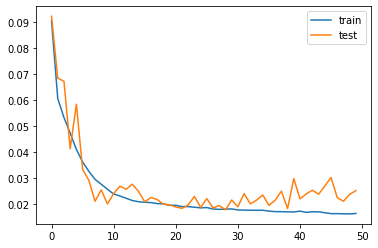

In [21]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [22]:
Y_pred = model.predict(test_X)

mse = mean_squared_error(test_y, Y_pred)

rmse = np.sqrt(mse)
rmse

0.02993060459500642

In [117]:
d = scaled_dataset[:8760,:]
Y_predic = np.concatenate((Y_pred,d[:8760,1:]), axis =1)
# print('concat y_pred',Y_pred.shape)
print(Y_predic[0])
Y_tested = np.concatenate((test_y, d[:8760,1:]), axis = 1)
# print('concat Y_test', test_y.shape)

[0.52372336 0.24092133 0.61321832 0.03103044 0.55688809 0.19262007
 0.59236179 0.00380735 0.42043586 0.19103092 0.61106557 0.20105082
 0.52063079 0.         0.         0.        ]


In [98]:
print(d)

[[0.5409399  0.24092133 0.61321832 ... 0.         0.         0.        ]
 [0.50539099 0.24373419 0.62044905 ... 0.         0.         0.        ]
 [0.49811449 0.24688035 0.63122022 ... 0.         0.         0.        ]
 ...
 [0.62861396 0.2775769  0.70616073 ... 0.         0.         0.        ]
 [0.60246142 0.26827476 0.71329914 ... 0.         0.         0.        ]
 [0.56354606 0.26256066 0.71682707 ... 0.         0.         0.        ]]


In [99]:
test_y

array([[0.49409188],
       [0.48525854],
       [0.51780425],
       ...,
       [0.53149897],
       [0.50939185],
       [0.49572933]])

In [97]:
print(Y_tested)

[[893.6865]
 [879.2323]
 [932.4876]
 ...
 [954.8966]
 [918.7222]
 [896.3659]]


In [91]:
print(Y_predic)

[[0.52372336 0.24092133 0.61321832 ... 0.         0.         0.        ]
 [0.53353381 0.24373419 0.62044905 ... 0.         0.         0.        ]
 [0.53015697 0.24688035 0.63122022 ... 0.         0.         0.        ]
 ...
 [0.54897988 0.2775769  0.70616073 ... 0.         0.         0.        ]
 [0.53664994 0.26827476 0.71329914 ... 0.         0.         0.        ]
 [0.51924825 0.26256066 0.71682707 ... 0.         0.         0.        ]]


In [96]:
Y_tested.shape

(8760, 1)

In [24]:
d.shape

(8760, 16)

In [25]:
d

array([[0.5409399 , 0.24092133, 0.61321832, ..., 0.        , 0.        ,
        0.        ],
       [0.50539099, 0.24373419, 0.62044905, ..., 0.        , 0.        ,
        0.        ],
       [0.49811449, 0.24688035, 0.63122022, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.62861396, 0.2775769 , 0.70616073, ..., 0.        , 0.        ,
        0.        ],
       [0.60246142, 0.26827476, 0.71329914, ..., 0.        , 0.        ,
        0.        ],
       [0.56354606, 0.26256066, 0.71682707, ..., 0.        , 0.        ,
        0.        ]])

In [26]:
#Scaling back to the original scale
Y_predicted = scaler.inverse_transform(Y_predic)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
print('Y_tested', Y_tested.shape)
print('Y_predicted', Y_predicted.shape)

Y_tested (8760, 1)
Y_predicted (8760, 1)


In [27]:
Y_predicted

array([[942.17319069],
       [958.22625386],
       [952.70064969],
       ...,
       [983.5010114 ],
       [963.32525102],
       [934.85045337]])

In [28]:
print(Y_tested)

[[893.6865]
 [879.2323]
 [932.4876]
 ...
 [954.8966]
 [918.7222]
 [896.3659]]


In [29]:
print(Y_predicted)

[[942.17319069]
 [958.22625386]
 [952.70064969]
 ...
 [983.5010114 ]
 [963.32525102]
 [934.85045337]]


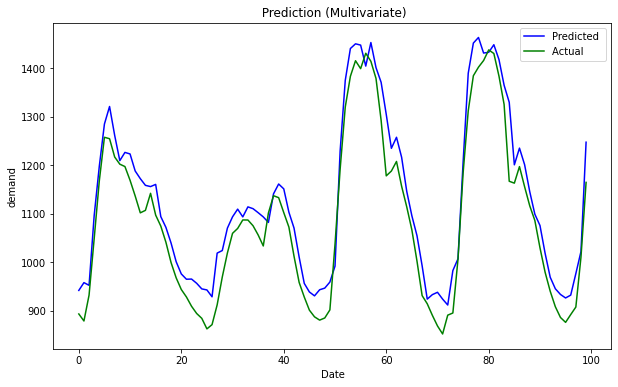

<Figure size 432x288 with 0 Axes>

In [30]:
#Plot the graph between actual vs predicted values
pyplot.figure(figsize=(10,6))  
pyplot.plot(Y_predicted[:100,:], color= 'blue',label = 'Predicted ')
pyplot.plot(Y_tested[:100,:] , color = 'green',label = 'Actual ')
pyplot.title(" Prediction (Multivariate)")
pyplot.xlabel("Date")
pyplot.ylabel("demand")
pyplot.legend()
pyplot.show()
pyplot.savefig('graph.png')

In [120]:
test_dataset=pd.read_csv("/content/Test.csv",header=0 ,index_col=0)

dec_2019=dataset_train.iloc[43031:,:]

total=pd.concat([dec_2019, test_dataset], axis=0)

print(total)

                  nat_demand    T2M_toc  QV2M_toc   TQL_toc    W2M_toc  \
datetime                                                                 
01-12-2019 00:00   1180.0710  25.967310  0.018335  0.059830  11.888873   
01-12-2019 01:00   1142.1314  25.810022  0.018312  0.067047  12.166300   
01-12-2019 02:00   1097.0180  25.681635  0.018274  0.068878  12.625126   
01-12-2019 03:00   1071.9436  25.555353  0.018180  0.064697  13.087129   
01-12-2019 04:00   1049.7786  25.464624  0.018035  0.051971  13.081646   
...                      ...        ...       ...       ...        ...   
31-01-2020 19:00      0.0000  26.784631  0.017690  0.010593  19.426609   
31-01-2020 20:00      0.0000  26.414575  0.017881  0.008904  17.925048   
31-01-2020 21:00      0.0000  26.165247  0.017990  0.008423  16.726263   
31-01-2020 22:00      0.0000  25.979059  0.017997  0.010746  16.620787   
31-01-2020 23:00      0.0000  25.821771  0.017967  0.016190  16.538011   

                    T2M_san  QV2M_san

In [121]:
print(total.shape)


(1488, 16)


In [122]:
values1 = total.values
values1

array([[1.18007100e+03, 2.59673096e+01, 1.83345340e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.14213140e+03, 2.58100220e+01, 1.83116090e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.09701800e+03, 2.56816345e+01, 1.82737190e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [0.00000000e+00, 2.61652466e+01, 1.79896170e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.59790588e+01, 1.79973500e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.58217712e+01, 1.79670600e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [123]:
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaled_dataset1 = scaler1.fit_transform(values1)
print(scaled_dataset1[0])
scaled_dataset1.shape

[0.68548373 0.29836212 0.5524668  0.20095325 0.26622123 0.21880516
 0.30791103 0.04555257 0.2902652  0.1839891  0.45075621 0.21499539
 0.45588252 0.         0.         1.        ]


(1488, 16)

In [124]:
def to_supervised(total):
  window_size = 4
  X1 = []
  Y1 = []
  for i in range(window_size, len(total)):
    X1.append(total[i-window_size:i,:])
    Y1.append(total[i,0:1])
    
  return X1,Y1
X1, Y1 = to_supervised(scaled_dataset1)
X1 = np.array(X1)
Y1 = np.array(Y1)
print('Y1' ,Y1.shape)
print('X1' ,X1.shape)

Y1 (1484, 1)
X1 (1484, 4, 16)


In [125]:
Y_pred1 = model.predict(X1)

In [126]:
Y_pred1.shape

(1484, 1)

In [127]:
scaled_dataset1.shape

(1488, 16)

In [128]:
d = scaled_dataset1[:1484,:]
Y_predicted_test = np.concatenate((Y_pred1,d[:1484,1:]), axis =1)
Y_predicted_test

array([[0.6029591 , 0.29836212, 0.5524668 , ..., 0.        , 0.        ,
        1.        ],
       [0.59508365, 0.27707709, 0.54827206, ..., 0.        , 0.        ,
        1.        ],
       [0.58463889, 0.25970298, 0.54133906, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.09154707, 0.64243708, 0.33966464, ..., 0.        , 0.        ,
        0.        ],
       [0.07951725, 0.49536223, 0.3829987 , ..., 0.        , 0.        ,
        0.        ],
       [0.08018768, 0.40896664, 0.43461631, ..., 0.        , 0.        ,
        0.        ]])

In [129]:
Y_predicted_test = scaler1.inverse_transform(Y_predicted_test)
Y_predicted_test = Y_predicted_test[:,0:1]

print('Y_predicted_test', Y_predicted_test.shape)

Y_predicted_test (1484, 1)


In [130]:
Y_predicted_test

array([[1038.00355097],
       [1024.44585305],
       [1006.46503417],
       ...,
       [ 157.59972162],
       [ 136.89018619],
       [ 138.0443472 ]])

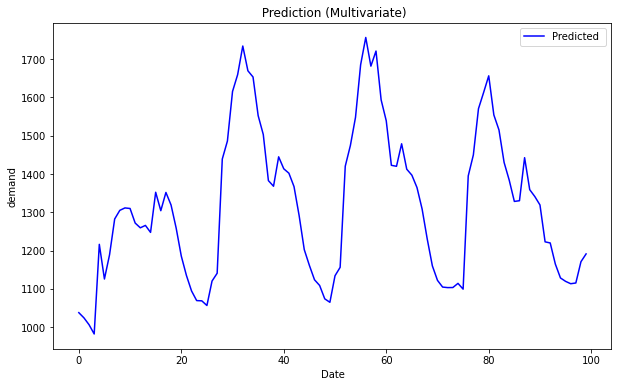

<Figure size 432x288 with 0 Axes>

In [131]:
pyplot.figure(figsize=(10,6))  
pyplot.plot(Y_predicted_test[:100,:], color= 'blue',label = 'Predicted ')
pyplot.title(" Prediction (Multivariate)")
pyplot.xlabel("Date")
pyplot.ylabel("demand")
pyplot.legend()
pyplot.show()
pyplot.savefig('graph.png')